In [1]:
from ast import List
from torchvision import transforms
from visualize_weights import *
import torch.nn.functional as F

import random, copy
import numpy as np
import torch, torchvision

/home/erastus/.virtualenvs/adv_ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# for training the target model
num_train_points = 5000
num_test_points = 5000
num_population_points = 10000
batch_size=64
learning_rate = 0.01
epochs=50

seed_value = 1
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define the model

In [3]:

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(3, 16, 5)
        self.pool = torch.nn.MaxPool2d(5, 5)
        self.fc = torch.nn.Linear(16 * 5 * 5, 10)

        torch.nn.init.xavier_normal_(self.conv.weight)
        if self.conv.bias is not None:
            torch.nn.init.constant_(self.conv.bias, 0)

        torch.nn.init.xavier_normal_(self.fc.weight)
        if self.fc.bias is not None:
            torch.nn.init.constant_(self.fc.bias, 0)

    def forward(self, inputs):
        """Forward pass of the model."""
        inputs = self.pool(F.relu(self.conv(inputs)))
        inputs = inputs.reshape(-1, 16 * 5 * 5)
        outputs = self.fc(inputs)
        return outputs
    
orig_model = Net()
conv_vec = [None, None, None, None]
fc_vec = [None, None, None, None]

# Create the data

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])
all_data = torchvision.datasets.CIFAR10(
    root='../../data/', train=True, download=True, transform=transform
)
test_data = torchvision.datasets.CIFAR10(
    root='../../data/', train=False, download=True, transform=transform
)

all_features = np.concatenate([all_data.data, test_data.data], axis=0)
all_targets = np.concatenate([all_data.targets, test_data.targets], axis=0)

all_data.data = all_features
all_data.targets = all_targets

all_index = np.arange(len(all_data))
train_index = np.random.choice(all_index, num_train_points, replace=False)
test_index = np.random.choice([i for i in all_index if i not in train_index], num_test_points, replace=False)
population_index = np.random.choice([i for i in all_index if i not in train_index and i not in test_index], num_population_points, replace=False)

Files already downloaded and verified
Files already downloaded and verified


Split the data into train, test and population

In [54]:
new_index = []
for elem in train_index:
    if not elem in indices:
        new_index.append(elem)
print(len(new_index), len(train_index))

4999 5000


Create the data loader for training the target model

In [55]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        data_idx = self.indices[idx]
        data, target = self.dataset[data_idx]
        return data, target, data_idx

train_loader = torch.utils.data.DataLoader(
            CustomDataset(all_data, new_index),
            #torch.utils.data.Subset(all_data,train_index),
            batch_size=batch_size,
            shuffle=False,
            num_workers=1,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=16)

test_loader = torch.utils.data.DataLoader(
            CustomDataset(all_data, test_index),
            #torch.utils.data.Subset(all_data,test_index),
            batch_size=batch_size,
            shuffle=False,
            num_workers=1,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=16)

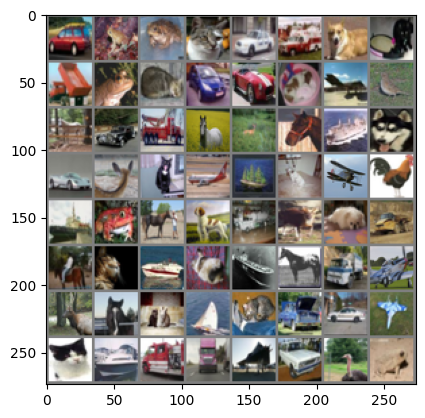

In [56]:
for image, label, indice in train_loader:
    images = image
    break
imshow(torchvision.utils.make_grid(images))

 # Define the target model

In [57]:
model = copy.deepcopy(orig_model)
device = 'cpu' # you can change it to 'cuda' if you have GPU
model.to(device)

Net(
  (conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=400, out_features=10, bias=True)
)

# Train the target model

In [58]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch_idx in range(epochs):
    train_loss = 0
    for data, target, indice in train_loader:
        data, target = data.to(device, non_blocking=True), target.to(device,non_blocking=True)
        target = target.long()
        optimizer.zero_grad(set_to_none=True)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch: {epoch_idx+1}/{epochs} |", end=" ")
    print(f"Loss: {train_loss/len(train_loader):.8f}")
model.eval()
loss, acc, criterion = 0, 0, torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for data, target, indice in train_loader:
        data, target = data.to(device), target.to(device)
        target = target.long()
        output = model(data)
        loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        acc += pred.eq(target.data.view_as(pred)).sum()
    loss /= len(train_loader)
    acc = float(acc) / len(train_loader.dataset)
    print("Train Loss: {:.4f}, Train Accuracy: {:.2f}%".format(loss, 100. * acc))
    for data, target, indice in test_loader:
        data, target = data.to(device), target.to(device)
        target = target.long()
        output = model(data)
        loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        acc += pred.eq(target.data.view_as(pred)).sum()
    loss /= len(test_loader)
    acc = float(acc) / len(test_loader.dataset)
    print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(loss, 100. * acc))

Epoch: 1/50 | Loss: 1.88146412
Epoch: 2/50 | Loss: 1.58842762
Epoch: 3/50 | Loss: 1.46206782
Epoch: 4/50 | Loss: 1.37364165
Epoch: 5/50 | Loss: 1.29474680
Epoch: 6/50 | Loss: 1.24374368
Epoch: 7/50 | Loss: 1.18979051
Epoch: 8/50 | Loss: 1.15384719
Epoch: 9/50 | Loss: 1.12860099
Epoch: 10/50 | Loss: 1.11757242
Epoch: 11/50 | Loss: 1.11597434
Epoch: 12/50 | Loss: 1.08967901
Epoch: 13/50 | Loss: 1.07491904
Epoch: 14/50 | Loss: 1.06134415
Epoch: 15/50 | Loss: 1.05228441
Epoch: 16/50 | Loss: 1.06283223
Epoch: 17/50 | Loss: 1.04486216
Epoch: 18/50 | Loss: 1.05303834
Epoch: 19/50 | Loss: 1.06219021
Epoch: 20/50 | Loss: 1.07258400
Epoch: 21/50 | Loss: 1.03687242
Epoch: 22/50 | Loss: 1.00120666
Epoch: 23/50 | Loss: 1.01717388
Epoch: 24/50 | Loss: 0.99869208
Epoch: 25/50 | Loss: 0.96111312
Epoch: 26/50 | Loss: 0.95583587
Epoch: 27/50 | Loss: 0.96198988
Epoch: 28/50 | Loss: 0.97250923
Epoch: 29/50 | Loss: 0.97852422
Epoch: 30/50 | Loss: 0.97703013
Epoch: 31/50 | Loss: 0.96937092
Epoch: 32/50 | Lo

In [38]:
model.to(device)
model.eval()
belongs, targets, indexs, entropies = [], [], [], []
for data, target, indice in train_loader:
    data, target = data.to(device), target.to(device)
    target = target.long()
    output = model(data)
    probabilities = F.softmax(output, dim=1)
    probabilities = torch.clamp(probabilities, min=1e-9, max=1-1e-9)
    entropy = -torch.sum(probabilities * torch.log(probabilities), dim=1)
    loss += criterion(output, target).item()
    pred = output.data.max(1, keepdim=True)[1]
    vec_true = pred.eq(target.data.view_as(pred))
    for idx, elem in enumerate(vec_true):
        if (elem.item() == False):
            belongs.append(data[idx])
            targets.append(target[idx])
            indexs.append(indice[idx])
            entropies.append(entropy[idx])
    acc += pred.eq(target.data.view_as(pred)).sum()
acc = float(acc) / len(test_loader.dataset)
print('*********** TEST ACCURACY: ', acc, len(belongs))

*********** TEST ACCURACY:  0.65868955078125 1707


In [39]:
print(min(entropies), max(entropies))
idx_min, idx_max = -1, -1
for i in range(len(entropies)):
    if entropies[i] == min(entropies):
        idx_min  = i
    if entropies[i] == max(entropies):
        idx_max = i
    if idx_min != -1 and idx_max != -1:
        break

tensor(0.0004, grad_fn=<SelectBackward0>) tensor(1.9796, grad_fn=<SelectBackward0>)


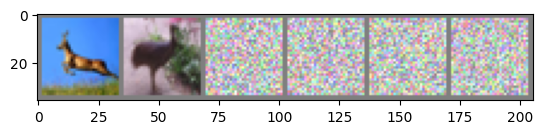

In [53]:
import copy
display = torch.rand(6, 3, 32, 32)
display[0] = copy.deepcopy(belongs[idx_min])
display[1] = copy.deepcopy(belongs[idx_max])
indices = [indexs[idx_max]]
cpt = 0
"""
for idx, image in enumerate(belongs):
    if entropies[idx] == min(entropies):
        display[cpt] = copy.deepcopy(image.cpu())
        indices.append(indexs[cpt])
        cpt +=1
        if cpt == display.size(0):
            break
"""
imshow(torchvision.utils.make_grid(display))

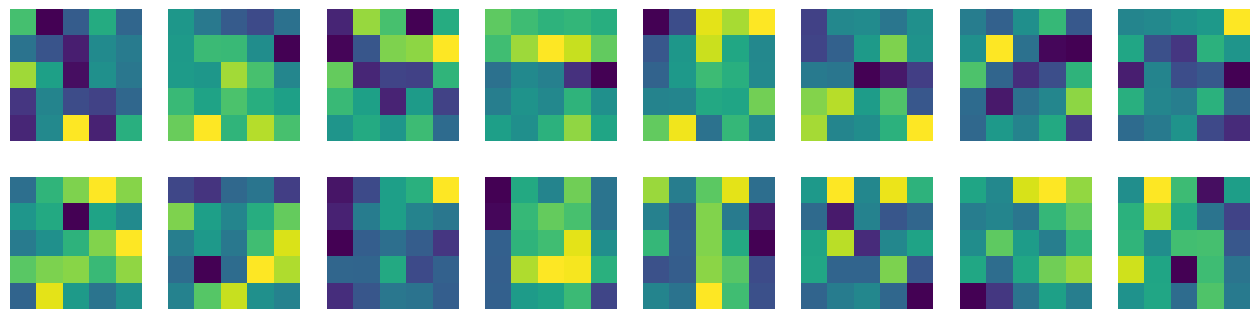

In [16]:
# Visualize the weights of the first convolutional layer
visualize_conv_layer_weights(model.conv.cpu())
orig_conv = copy.deepcopy(model.conv.cpu())

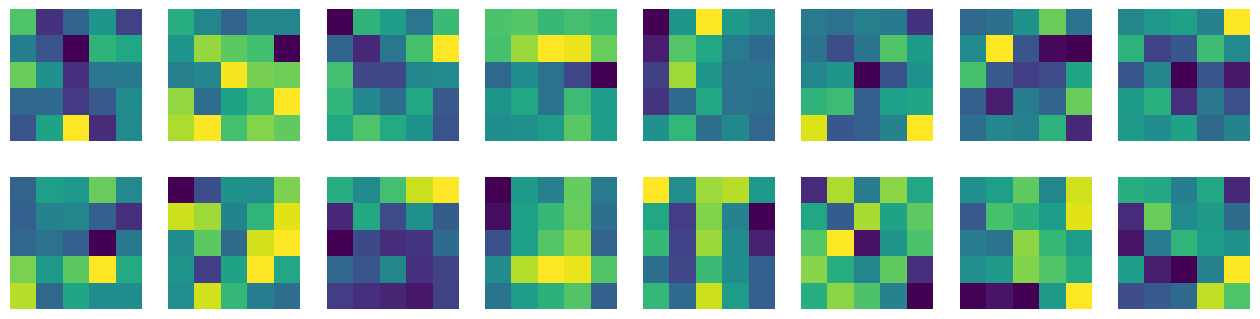

In [59]:
# Visualize the weights of the first convolutional layer
visualize_conv_layer_weights(model.conv.cpu())
conv_vec[3] = copy.deepcopy(model.conv.cpu())

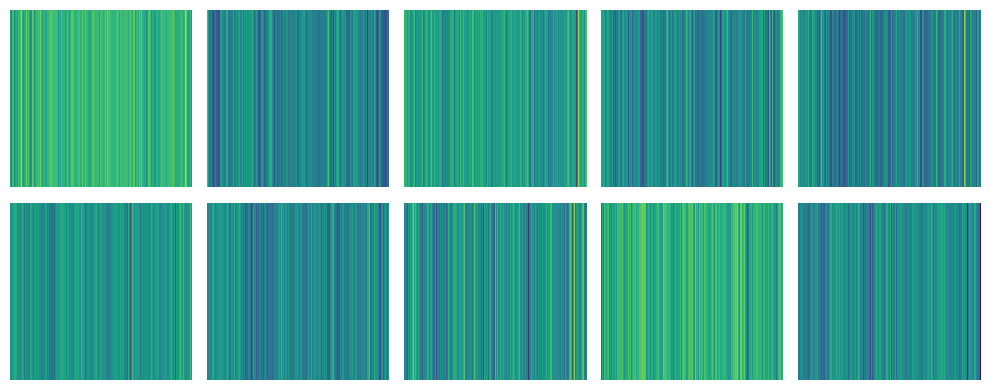

In [17]:
# Visualize the weights of the first linear layer
visualize_linear_layer_weights(model.fc.cpu())
orig_fc = copy.deepcopy(model.fc.cpu())

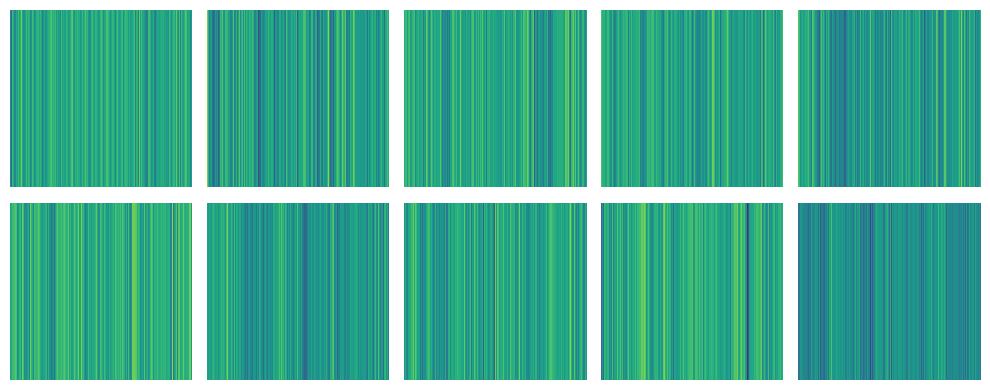

In [60]:
# Visualize the weights of the first linear layer
visualize_linear_layer_weights(model.fc.cpu())
fc_vec[3] = copy.deepcopy(model.fc.cpu())

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

def compute_correlation_between_corresponding_kernels(conv1_weights, conv2_weights):
    if conv1_weights.shape[0] != conv2_weights.shape[0]:
        raise ValueError("The number of kernels (filters) in each convolutional layer must be the same.")
    
    conv1_kernels_flat = conv1_weights.view(conv1_weights.shape[0], -1)
    conv2_kernels_flat = conv2_weights.view(conv2_weights.shape[0], -1)
    num_kernels = conv1_kernels_flat.shape[0]
    correlations = np.zeros(num_kernels)
    for i in range(num_kernels):
        kernel1 = conv1_kernels_flat[i].numpy()
        kernel2 = conv2_kernels_flat[i].numpy()
        correlations[i] = np.corrcoef(kernel1, kernel2)[0, 1]
    return correlations

def plot_correlations(correlations, path):
    plt.figure(figsize=(7, 3))
    plt.bar(range(len(correlations)), correlations, color='skyblue')
    plt.xlabel('Kernel Index')
    plt.ylabel('Pearson Correlation Coefficient')
    plt.title('Perason Correlation between Conv Kernels')
    plt.ylim(-0.5, 1)
    plt.axhline(y=0.7, color='r', linestyle='--', label='Threshold (y=0.7)')
    plt.savefig(path, dpi=300, bbox_inches='tight') 

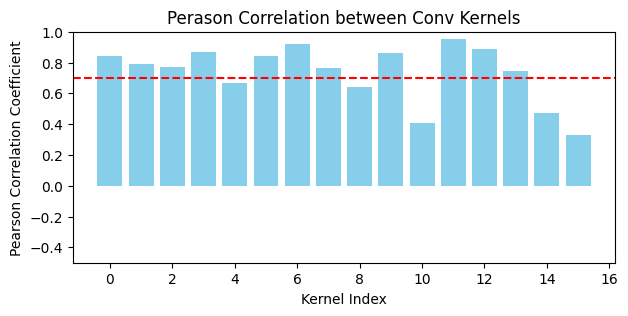

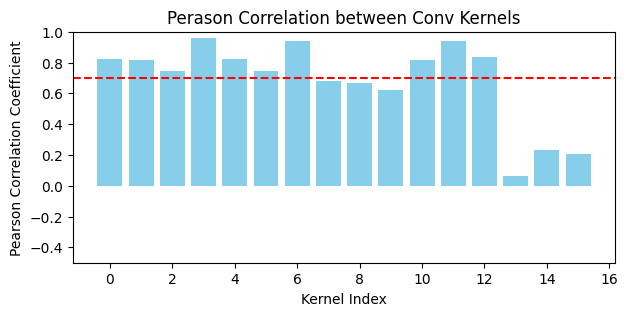

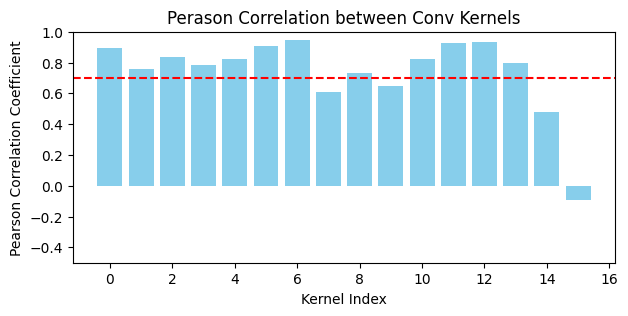

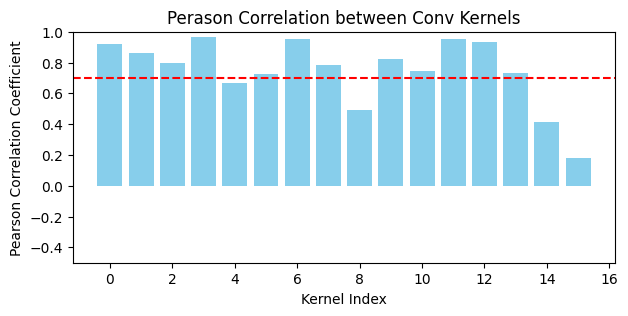

In [62]:
for idx, elem in enumerate(conv_vec):
    correlations = compute_correlation_between_corresponding_kernels(elem.weight.data, orig_conv.weight.data)
    plot_correlations(correlations, './xavier_conv_test_'+str(idx+1))

In [63]:
def compute_correlation_between_corresponding_rows(linear1_weights, linear2_weights):
    if linear1_weights.shape[0] != linear2_weights.shape[0]:
        raise ValueError("The number of output features in each linear layer must be the same.")
    num_rows = linear1_weights.shape[0]
    correlations = np.zeros(num_rows)

    for i in range(num_rows):
        row1 = linear1_weights[i].numpy()
        row2 = linear2_weights[i].numpy()
        correlations[i] = np.corrcoef(row1, row2)[0, 1]

    return correlations

def plot_correlations(correlations, path):
    plt.figure(figsize=(7, 3))
    plt.bar(range(len(correlations)), correlations, color='skyblue')
    plt.xlabel('Row Index')
    plt.ylabel('Pearson Correlation Coefficient')
    plt.title('Correlation between FC Neurons')
    plt.ylim(-0.5, 1)
    plt.axhline(y=0.7, color='r', linestyle='--', label='Threshold (y=0.7)')
    plt.savefig(path, dpi=300, bbox_inches='tight') 

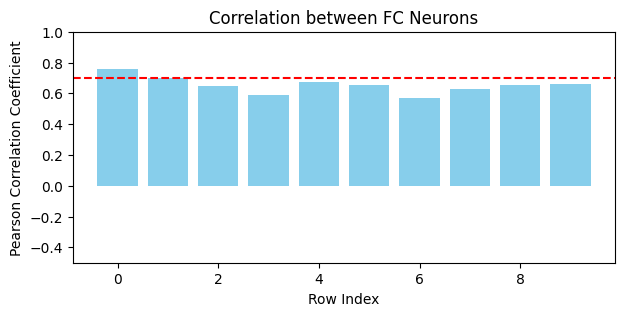

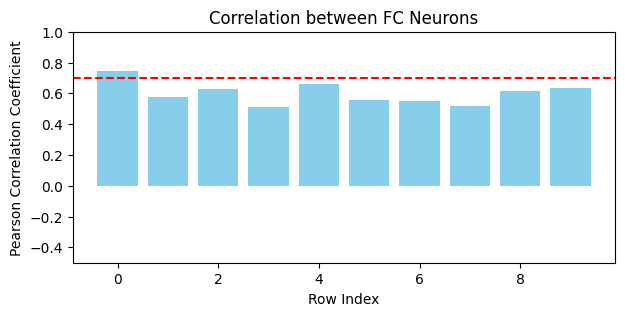

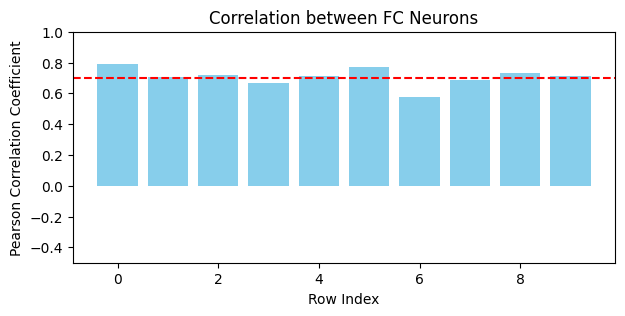

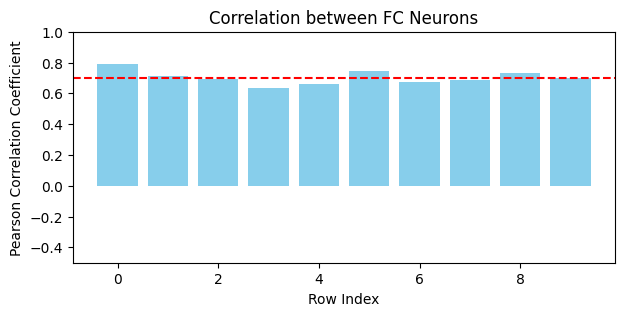

In [66]:
for idx, elem in enumerate(fc_vec):
    correlations = compute_correlation_between_corresponding_kernels(elem.weight.data, orig_fc.weight.data)
    plot_correlations(correlations, './xavier_fc_test_'+str(idx+1))

In [65]:
"""
- See whether the inclusion/removal of specific data sample results in high perturbations of the weights
- What types of data samples can I remove from the training set?
	- All samples || 65.86% , 44.77%
	- Correctly Classified Easy Samples -> True + low entropy (high uncertaininty) || 62.85% , 44.33%
	- Correctly Classified Diffuclt Samples -> True + high entropy (high uncertaininty) || 66.99% , 46.03%
	- Wrongly Classified Easy Samples -> False + low entropy (high uncertaininty) || 64.75% , 46.49%
	- Wrongly Classified Diffuclt Samples -> False + high entropy (high uncertaininty) || 62.15% , 44.71%
"""

'\n- See whether the inclusion/removal of specific data sample results in high perturbations of the weights\n- What types of data samples can I remove from the training set?\n\t- All samples || 65.86% , 44.77%\n\t- Correctly Classified Easy Samples -> True + low entropy (high uncertaininty) || 62.85% , 44.33%\n\t- Correctly Classified Diffuclt Samples -> True + high entropy (high uncertaininty) || 66.99% , 46.03%\n\t- Wrongly Classified Easy Samples -> False + low entropy (high uncertaininty) || 64.75% , 46.49%\n\t- Wrongly Classified Diffuclt Samples -> False + high entropy (high uncertaininty) || 62.15% , 44.71%\n'